In [84]:
import torch
from time import time
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np 
from torch.storage import T
from scipy.stats import entropy
import math

1-gaussien stein kernel

In [4]:
def gaussian_stein_kernel(  x, y, scores_x, scores_y, sigma, return_kernel=False):

    _, p = x.shape#donner le dimension de x
    d = x[:, None, :] - y[None, :, :] #on fait celle ci car on traite la matrice X comme etant tous les X , si on fait X -Y elle va pas donner la resultat voulu 
    dists = (d ** 2).sum(axis=-1) #calculer la distance 
    k = torch.exp(-dists / sigma / 2) #gaussien kernel implementation 
    scalars = scores_x.mm(scores_y.T)
    scores_diffs = scores_x[:, None, :] - scores_y[None, :, :]
    diffs = (d * scores_diffs).sum(axis=-1)
    der2 = p - dists / sigma
    stein_kernel = k * (scalars + diffs / sigma + der2 / sigma)# calculer stein kernel 
    if return_kernel:
        return stein_kernel, k,d
    return stein_kernel

In [5]:
def kill(x, kill_inds):
    survivor_inds = torch.tensor(list(set(range(x.shape[0]))-set(kill_inds)), dtype=torch.long)#donner l'ensemble des indices des particules qui vont pas etre eliminer
    x = torch.index_select(x,0,survivor_inds)#choisir les particules qui restent aprés le processus naissance mort
    return x

In [153]:
def new_death_birth(x0, score, step,max_iter=1000, bw=1,store=False, alpha=1,birth_death=False):
    x = x0.clone().detach()
    plt.scatter(x[:, 0], x[:, 1], s=3, color="green", zorder=1)#dessiner les particules a l'etat initiale
    n_samples, p = x.shape
    x.requires_grad = True
    if store:
        storage = []#storer la liste de l'ensemble de x d'ou la trajectoire ksd
        timer = []#stocker les temps de nos particules  
        t0 = time()#initialliser le
    loss_list = [] #initialiser la liste contenant la fonction "loss"
    for i in range(max_iter + 1):
        if store:
            timer.append(time() - t0)
            storage.append(x.clone())
        scores_x = score(x)
        K =  gaussian_stein_kernel(x, x, scores_x, scores_x,bw)
        loss = K.sum() / n_samples ** 2 #calcul de loss function
        loss.backward()
        loss_list.append(loss.item())
        with torch.no_grad():
            x[:] -= step * x.grad  #mettre a jour la position des particules avec le ksd descent algorithme 
            x.grad.data.zero_()
        if birth_death==True: 
            K =  gaussian_stein_kernel(x, x, scores_x, scores_x,bw) #calculer le kernel stein
            potentiel=K.sum(axis=1)/n_samples
            moyenne=potentiel.sum()/n_samples
            new_val=potentiel-moyenne
            ext=new_val.detach()
            d = (x[:, None, :] - x[None, :, :])
            dists = (d ** 2).sum(axis=-1) #dists: ||x_i-x_j||^2 matrix
            nx = torch.sqrt(dists)
#             print(torch.count_nonzero(nx))
            kill_inds = []
            n_cloned = 0
            for j in range(n_samples):     
                p = 1-np.exp(-alpha * ext[j]) # le calcul de l'element sous laquelle on va faire l'elimination des particules puisqu"il est aleatoire
                r = np.random.rand()
                if ext[j] > 0:
                    if r < p:

                      kill_inds.append(j) #preparer la liste de kill_inds contenant les indices des particules qui vont etre eliminer

                elif r < (1-np.exp(alpha * ext[j])):
                    
                    x= torch.cat((x,((x[j,:]).reshape(1,2))))#doubler la particule 
                    n_cloned+=1
#                     c=(nx.detach()).numpy()
#                     l1=(torch.nonzero(nx)).tolist()
#                     l2=[]
#                     for i in l1 :
#                       l2.append(c[i[0],i[1]])
                

            # tuer les particules qui figure dans la liste 
            x = kill(x,kill_inds).clone().detach()
            # ajouter les particules monquantes pour avoir le meme nombre de particules 
            delta_n = n_cloned-len(kill_inds)
            if delta_n<0:
                clone_inds = torch.randint(n_samples+delta_n,(-delta_n,), dtype=torch.long)
                x = torch.cat((x,torch.index_select(x,0,clone_inds))).clone().detach()

            if delta_n>0:
                kill_inds = (torch.randperm(x.shape[0], dtype=torch.int)[:delta_n]).numpy()
                x = kill(x,kill_inds).clone().detach()
        x.requires_grad = True
    x.requires_grad=True
    if store:
            timer.append(time() - t0)
            storage.append(x.clone())#ajouter les particules en cours d'incrementation
    scores_x = score(x)
    K =  gaussian_stein_kernel(x, x, scores_x, scores_x,bw)
    loss = K.sum() / n_samples ** 2
    loss.backward()
    loss_list.append(loss.item())
    with torch.no_grad():
            x[:] -= step * x.grad
            x.grad.data.zero_()    
    x.requires_grad = False
    x3=x.clone().detach()
    #dessiner la figures des particules a l'etat finale
    plt.scatter(x3[:, 0], x3[:, 1], s=3, color="orange", zorder=1)
    plt.legend(["particles at initial position ", "particles at final position"])
    x_ = np.linspace(-7, 7)
    y_ = np.linspace(-5, 5)
    X, Y = np.meshgrid(x_, y_)
    XX = torch.tensor(np.array([X.ravel(), Y.ravel()]).T)
    Z = potential(XX).reshape(X.shape).detach().numpy()
    plt.contour(X, Y, Z, levels=5, colors="k", alpha=0.6)

    x_ = np.linspace(min(x_), max(x_), 20)
    y_ = np.linspace(min(y_), max(y_), 20)
    X, Y = np.meshgrid(x_, y_)
    XX = torch.tensor(np.array([X.ravel(), Y.ravel()]).T)
    score_z = score(XX)
    u = score_z[:, 0].reshape(X.shape).detach().numpy()
    v = score_z[:, 1].reshape(X.shape).detach().numpy()
    plt.quiver(X, Y, u, v, color="red", alpha=0.2)
    plt.tick_params(
                    axis="both",
                    which="both",
                    bottom=False,
                    top=False,
                    labelbottom=False,
                    left=False,
                    right=False,
                    labelleft=False,
                )
    plt.xlim(min(x_), max(x_))
    plt.ylim(min(y_), max(y_))
   
    if birth_death==True: #conditionnement pour la legende des figures 
        plt.title("KSD WITH Birth_death with step_size "+str(step)+"Nombre iterations"+str(max_iter))
        plt.show()
    else: 
        plt.title("KSD WITH step_size "+str(step)+"nombre_iterations"+str(max_iter))
        plt.show()
    if store:
        return x,timer,loss_list
    else:
        return x

KSD with simple gaussien 

In [154]:
def potential(x):
    return (x ** 2).sum(dim=1)
def score(x):
    return -x/0.3

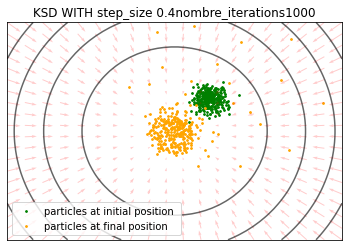

In [156]:
n_samples = 300 
p = 2
x = 1.5 + torch.randn(n_samples, p) / 3 #initialliser les particules 
bw = 1
x1,t1,ls1=new_death_birth(x.clone(), score, 0.4,max_iter=1000,bw=bw,store=True)

KSD with mixture gaussien

In [9]:
def make_mog(centers, vars, weights):
    weights = torch.tensor(weights)
    weights /= weights.sum()

    def score(x): #donner le score pour  mixte gaussienne
        den = 0
        top = 0
        for center, var, weight in zip(centers, vars, weights):
            exp = torch.exp(-0.5 * ((x - center) ** 2).sum(axis=1) / var)
            den += weight * exp
            top += weight * exp[:, None] * (x - center) / var
        return -top / den[:, None]

    def potential(x):  #donner le  potentiel pour mixte gaussienne 
        op = 0.0
        for center, var, weight in zip(centers, vars, weights):
            exp = torch.exp(-0.5 * ((x - center) ** 2).sum(axis=1) / var)
            op += weight * exp
        return torch.log(op)

    def sampler(n_samples):#generer des echantillons d'une mixte gaussienne 
        x = []
        for c, v, w in zip(centers, vars, weights):
            z = torch.randn(int(n_samples * w), 2)
            z *= np.sqrt(v)
            z += c
            x.append(z.clone())
        return torch.cat(x)

    return score, potential, sampler

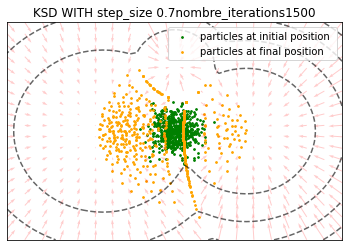

In [15]:
fac = 1
centers = [
    torch.tensor([-3, 0]),
    torch.tensor([3, 0.0]),
    torch.tensor([0.0, 3.0]),
]
# centers = [torch.tensor([0., 1.]), torch.tensor([0., -1])]
variances = [0.5, 0.3, 0.1]
weights = [0.5, 0.5, 0.5]
score, potential, sampler = make_mog(centers, variances, weights)

n_samples = 600
p = 2


x = 0.5 * torch.randn(n_samples, p)
bw = 0.1
x1,t1,ls1=new_death_birth(x.clone(), score, 0.7,max_iter=1500,bw=bw,store=True,birth_death=False)

Tracage de courbe de ksd avec birth death et sans 

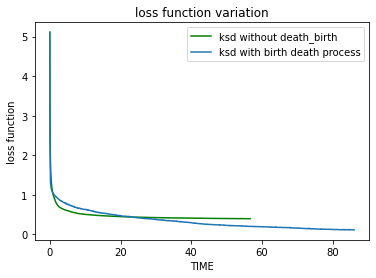

In [82]:
plt.plot(t2,ls2,color='g',label='ksd without death_birth ')
plt.plot(t1,ls1,label="ksd with birth death process")
plt.xlabel("TIME")
plt.ylabel("loss function")
plt.title("loss function variation")
plt.legend()
plt.show()

birth death with noise

In [75]:
def new_death_birth_withnoise(x0, score, step,max_iter=1000, bw=1,store=False, alpha=1,birth_death=False):
    
    x = x0.clone().detach()
    plt.scatter(x[:, 0], x[:, 1], s=3, color="green", zorder=1)
    n_samples, p = x.shape
    x.requires_grad = True
    d = (x[:, None, :] - x[None, :, :])
    dists = (d ** 2).sum(axis=-1)
    nx = torch.sqrt(dists)
    l3=[]
    l3.append(torch.count_nonzero(nx))
    if store:
        storage = []#storage la liste de l'ensemble de x d'ou la trajectoire ksd
        timer = []#stocker les temps de nos particules  
        t0 = time()#initialliser le
    loss_list = []
    for i in range(max_iter + 1):
        if store:
            timer.append(time() - t0)
            storage.append(x.clone())
        scores_x = score(x)
        K =  gaussian_stein_kernel(x, x, scores_x, scores_x,bw)
        loss = K.sum() / n_samples ** 2 #calcul de loss function
        loss.backward()
        loss_list.append(loss.item())
        with torch.no_grad():
            x[:] -= step * x.grad  #update particles 
            x.grad.data.zero_()
        if birth_death==True: 
            K =  gaussian_stein_kernel(x, x, scores_x, scores_x,bw)
            potentiel=K.sum(axis=1)/n_samples
            moyenne=potentiel.sum()/n_samples
            new_val=potentiel-moyenne
            ext=new_val.detach()
            d = (x[:, None, :] - x[None, :, :])
            dists = (d ** 2).sum(axis=-1) #dists: ||x_i-x_j||^2 matrix
            nx = torch.sqrt(dists)
            l3.append(torch.count_nonzero(nx))#construire une liste contenant le nombres des particules distinctes
            print(torch.count_nonzero(nx))
            kill_inds = []
            n_cloned = 0
            for j in range(n_samples):     
                p = 1-np.exp(-alpha * ext[j]) # note that subtracting the mean is optional for this example; it does not affect the fixed point
                r = np.random.rand()
                if ext[j] > 0:
                    if r < p:

                      kill_inds.append(j)

                elif r < (1-np.exp(alpha * ext[j])):
                    c=(nx.detach()).numpy()
                    l1=(torch.nonzero(nx)).tolist()#recuperer l'indice des distances nulles
                    l2=[]
                    for i in l1 :
                      l2.append(c[i[0],i[1]])#construire une liste contenant les distance non nulles
                    x= torch.cat((x,((x[j,:]+min(l2)).reshape(1,2))))
                    n_cloned+=1

            # eliminer les particules 
            x = kill(x,kill_inds).clone().detach()
            delta_n = n_cloned-len(kill_inds)
            if delta_n<0:
                clone_inds = torch.randint(n_samples+delta_n,(-delta_n,), dtype=torch.long)
                x = torch.cat((x,torch.index_select(x,0,clone_inds))).clone().detach()

            if delta_n>0:
                kill_inds = (torch.randperm(x.shape[0], dtype=torch.int)[:delta_n]).numpy()
                x = kill(x,kill_inds).clone().detach()
        x.requires_grad = True
    x.requires_grad=True
    if store:
            timer.append(time() - t0)
            storage.append(x.clone())
    scores_x = score(x)
    K =  gaussian_stein_kernel(x, x, scores_x, scores_x,bw)
    loss = K.sum() / n_samples ** 2
    loss.backward()
    loss_list.append(loss.item())#construire la liste contenant le "loss"
    with torch.no_grad():
            x[:] -= step * x.grad
            x.grad.data.zero_()    
    x.requires_grad = False
    x3=x.clone().detach()
    plt.scatter(x3[:, 0], x3[:, 1], s=3, color="orange", zorder=1)
    plt.legend(["particles at initial position","paricles at final position"])
    x_ = np.linspace(-7, 7)
    y_ = np.linspace(-5, 5)
    X, Y = np.meshgrid(x_, y_)
    XX = torch.tensor(np.array([X.ravel(), Y.ravel()]).T)
    Z = potential(XX).reshape(X.shape).detach().numpy()
    plt.contour(X, Y, Z, levels=5, colors="k", alpha=0.6)

    x_ = np.linspace(min(x_), max(x_), 20)
    y_ = np.linspace(min(y_), max(y_), 20)
    X, Y = np.meshgrid(x_, y_)
    XX = torch.tensor(np.array([X.ravel(), Y.ravel()]).T)
    score_z = score(XX)
    u = score_z[:, 0].reshape(X.shape).detach().numpy()
    v = score_z[:, 1].reshape(X.shape).detach().numpy()
    plt.quiver(X, Y, u, v, color="red", alpha=0.2)
    plt.tick_params(
                    axis="both",
                    which="both",
                    bottom=False,
                    top=False,
                    labelbottom=False,
                    left=False,
                    right=False,
                    labelleft=False,
                )
    plt.xlim(min(x_), max(x_))
    plt.ylim(min(y_), max(y_))
   
    if birth_death==True: 
        plt.title("KSD WITH Birth_death with step_size "+str(step)+"Nombre iterations"+str(max_iter))
        plt.show()
    else: 
        plt.title("KSD WITH step_size "+str(step)+"nombre_iterations"+str(max_iter))
        plt.show()
    if store:
        return x,timer,loss_list,l3
    else:
        return x

In [73]:
def make_mog(centers, vars, weights):
    weights = torch.tensor(weights)
    weights /= weights.sum()

    def score(x): 
        den = 0
        top = 0
        for center, var, weight in zip(centers, vars, weights):
            exp = torch.exp(-0.5 * ((x - center) ** 2).sum(axis=1) / var)
            den += weight * exp
            top += weight * exp[:, None] * (x - center) / var
        return -top / den[:, None]

    def potential(x): 
        op = 0.0
        for center, var, weight in zip(centers, vars, weights):
            exp = torch.exp(-0.5 * ((x - center) ** 2).sum(axis=1) / var)
            op += weight * exp
        return torch.log(op)

    def sampler(n_samples): 
        x = []
        for c, v, w in zip(centers, vars, weights):
            z = torch.randn(int(n_samples * w), 2)
            z *= np.sqrt(v)
            z += c
            x.append(z.clone())
        return torch.cat(x)

    return score, potential, sampler

tensor(9900)
tensor(9900)
tensor(9900)
tensor(9900)
tensor(9900)
tensor(9900)
tensor(9898)
tensor(9898)
tensor(9900)
tensor(9890)
tensor(9864)
tensor(9860)
tensor(9860)
tensor(9838)
tensor(9834)
tensor(9828)
tensor(9836)
tensor(9846)
tensor(9830)
tensor(9812)
tensor(9794)
tensor(9804)
tensor(9800)
tensor(9796)
tensor(9790)
tensor(9772)
tensor(9772)
tensor(9738)
tensor(9752)
tensor(9740)
tensor(9728)
tensor(9726)
tensor(9730)
tensor(9712)
tensor(9698)
tensor(9704)
tensor(9724)
tensor(9704)
tensor(9700)
tensor(9688)
tensor(9676)
tensor(9686)
tensor(9712)
tensor(9726)
tensor(9768)
tensor(9756)
tensor(9746)
tensor(9764)
tensor(9754)
tensor(9764)
tensor(9770)
tensor(9772)
tensor(9784)
tensor(9754)
tensor(9786)
tensor(9770)
tensor(9770)
tensor(9776)
tensor(9738)
tensor(9766)
tensor(9738)
tensor(9724)
tensor(9748)
tensor(9746)
tensor(9742)
tensor(9736)
tensor(9732)
tensor(9734)
tensor(9748)
tensor(9734)
tensor(9766)
tensor(9774)
tensor(9770)
tensor(9758)
tensor(9750)
tensor(9758)
tensor(9720)

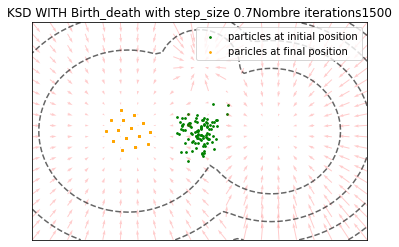

In [76]:
fac = 1
centers = [
    torch.tensor([-3, 0]),
    torch.tensor([3, 0.0]),
    torch.tensor([0.0, 3.0]),
]
# centers = [torch.tensor([0., 1.]), torch.tensor([0., -1])]
variances = [0.5, 0.3, 0.1]
weights = [0.5, 0.5, 0.5]
score, potential, sampler = make_mog(centers, variances, weights)

n_samples = 100
p = 2


x = 0.5 * torch.randn(n_samples, p)
bw = 0.1
x2,t2,ls2,l2=new_death_birth_withnoise(x.clone(), score, 0.7,max_iter=1500,bw=bw,store=True,birth_death=True)

In [55]:
x1,t1,ls1,l1

(tensor([[-2.2913,  0.4524],
         [-2.9990, -0.0127],
         [-3.3662,  0.2972],
         [-2.9990, -0.0127],
         [-3.2065,  0.8123],
         [-2.7623, -0.9556],
         [-3.8368,  0.0540],
         [-2.8204,  0.4449],
         [-2.7623, -0.9556],
         [-2.9990, -0.0127],
         [-2.2913,  0.4524],
         [-2.8948, -0.4614],
         [-2.0138, -0.0545],
         [-3.8368,  0.0540],
         [-2.0138, -0.0545],
         [-3.3976, -0.2627],
         [-2.9990, -0.0127],
         [-2.8204,  0.4449],
         [-3.2065,  0.8123],
         [-3.2065,  0.8123],
         [-3.3112, -0.7851],
         [-3.3662,  0.2972],
         [-2.2913,  0.4524],
         [-2.0138, -0.0545],
         [-3.7685,  0.6403],
         [-3.8368,  0.0540],
         [-2.8204,  0.4449],
         [-3.8421, -0.5363],
         [-2.5320, -0.0296],
         [-2.8948, -0.4614],
         [-3.2065,  0.8123],
         [-3.3662,  0.2972],
         [-3.8368,  0.0540],
         [-2.8204,  0.4449],
         [-3.3

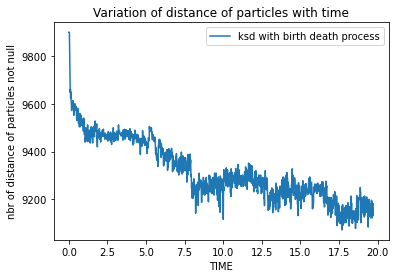

In [65]:

plt.plot(t2,l2,label="ksd with birth death process")
plt.xlabel("TIME")
plt.ylabel("nbr of distance of particles not null")
plt.title("Variation of distance of particles with time")
plt.legend()
plt.show()

In [ ]:
plt.plot(t1,l2,label="ksd with birth death process")
plt.plot(t2,l2,label="ksd with birth death process")
plt.xlabel("TIME")
plt.ylabel("nbr of distance of particles not null")
plt.title("Variation of distance of particles with time")
plt.legend()
plt.show()

Eliminer le bruit pour comparer la vaariation de nombres de particules distinctes

In [77]:
def new_death_birth_withnoise1(x0, score, step,max_iter=1000, bw=1,store=False, alpha=1,birth_death=False):
    
    x = x0.clone().detach()
    plt.scatter(x[:, 0], x[:, 1], s=3, color="green", zorder=1)
    n_samples, p = x.shape
    x.requires_grad = True
    d = (x[:, None, :] - x[None, :, :])
    dists = (d ** 2).sum(axis=-1)
    nx = torch.sqrt(dists)
    l3=[]
    l3.append(torch.count_nonzero(nx))
    epsilon=np.random.normal(0,1, size=10001)
    if store:
        storage = []#storage la liste de l'ensemble de x d'ou la trajectoire ksd
        timer = []#stocker les temps de nos particules  
        t0 = time()#initialliser le
    loss_list = []
    for i in range(max_iter + 1):
        if store:
            timer.append(time() - t0)
            storage.append(x.clone())
        scores_x = score(x)
        K =  gaussian_stein_kernel(x, x, scores_x, scores_x,bw)
        loss = K.sum() / n_samples ** 2 #calcul de loss function
        loss.backward()
        loss_list.append(loss.item())
        with torch.no_grad():
            x[:] -= step * x.grad  #update particles 
            x.grad.data.zero_()
        if birth_death==True: 
            K =  gaussian_stein_kernel(x, x, scores_x, scores_x,bw)
            potentiel=K.sum(axis=1)/n_samples
            moyenne=potentiel.sum()/n_samples
            new_val=potentiel-moyenne
            ext=new_val.detach()
            d = (x[:, None, :] - x[None, :, :])
            dists = (d ** 2).sum(axis=-1) #dists: ||x_i-x_j||^2 matrix
            nx = torch.sqrt(dists)
            l3.append(torch.count_nonzero(nx))
            print(torch.count_nonzero(nx))
            kill_inds = []
            n_cloned = 0
            for j in range(n_samples):     
                p = 1-np.exp(-alpha * ext[j]) # note that subtracting the mean is optional for this example; it does not affect the fixed point
                r = np.random.rand()
                if ext[j] > 0:
                    if r < p:

                      kill_inds.append(j)

                elif r < (1-np.exp(alpha * ext[j])):
#                     c=(nx.detach()).numpy()
#                     l1=(torch.nonzero(nx)).tolist()
#                     l2=[]
#                     for i in l1 :
#                       l2.append(c[i[0],i[1]])
                    x= torch.cat((x,((x[j,:]).reshape(1,2))))
                    n_cloned+=1

            # now kill the particles on the kill list
            x = kill(x,kill_inds).clone().detach()
            # and resample to control population
            delta_n = n_cloned-len(kill_inds)
            if delta_n<0:
                clone_inds = torch.randint(n_samples+delta_n,(-delta_n,), dtype=torch.long)
                x = torch.cat((x,torch.index_select(x,0,clone_inds))).clone().detach()

            if delta_n>0:
                kill_inds = (torch.randperm(x.shape[0], dtype=torch.int)[:delta_n]).numpy()
                x = kill(x,kill_inds).clone().detach()
        x.requires_grad = True
    x.requires_grad=True
    if store:
            timer.append(time() - t0)
            storage.append(x.clone())
    scores_x = score(x)
    K =  gaussian_stein_kernel(x, x, scores_x, scores_x,bw)
    loss = K.sum() / n_samples ** 2
    loss.backward()
    loss_list.append(loss.item())
    with torch.no_grad():
            x[:] -= step * x.grad
            x.grad.data.zero_()    
    x.requires_grad = False
    x3=x.clone().detach()
    plt.scatter(x3[:, 0], x3[:, 1], s=3, color="orange", zorder=1)
    plt.legend(["particles at initial position","paricles at final position"])
    x_ = np.linspace(-7, 7)
    y_ = np.linspace(-5, 5)
    X, Y = np.meshgrid(x_, y_)
    XX = torch.tensor(np.array([X.ravel(), Y.ravel()]).T)
    Z = potential(XX).reshape(X.shape).detach().numpy()
    plt.contour(X, Y, Z, levels=5, colors="k", alpha=0.6)

    x_ = np.linspace(min(x_), max(x_), 20)
    y_ = np.linspace(min(y_), max(y_), 20)
    X, Y = np.meshgrid(x_, y_)
    XX = torch.tensor(np.array([X.ravel(), Y.ravel()]).T)
    score_z = score(XX)
    u = score_z[:, 0].reshape(X.shape).detach().numpy()
    v = score_z[:, 1].reshape(X.shape).detach().numpy()
    plt.quiver(X, Y, u, v, color="red", alpha=0.2)
    plt.tick_params(
                    axis="both",
                    which="both",
                    bottom=False,
                    top=False,
                    labelbottom=False,
                    left=False,
                    right=False,
                    labelleft=False,
                )
    plt.xlim(min(x_), max(x_))
    plt.ylim(min(y_), max(y_))
   
    if birth_death==True: 
        plt.title("KSD WITH Birth_death with step_size "+str(step)+"Nombre iterations"+str(max_iter))
        plt.show()
    else: 
        plt.title("KSD WITH step_size "+str(step)+"nombre_iterations"+str(max_iter))
        plt.show()
    if store:
        return x,timer,loss_list,l3
    else:
        return x

tensor(9900)
tensor(9836)
tensor(9770)
tensor(9680)
tensor(9684)
tensor(9660)
tensor(9628)
tensor(9652)
tensor(9646)
tensor(9604)
tensor(9608)
tensor(9638)
tensor(9602)
tensor(9590)
tensor(9612)
tensor(9596)
tensor(9574)
tensor(9616)
tensor(9608)
tensor(9604)
tensor(9594)
tensor(9580)
tensor(9554)
tensor(9574)
tensor(9570)
tensor(9580)
tensor(9586)
tensor(9566)
tensor(9552)
tensor(9566)
tensor(9584)
tensor(9570)
tensor(9584)
tensor(9550)
tensor(9526)
tensor(9470)
tensor(9552)
tensor(9556)
tensor(9534)
tensor(9562)
tensor(9558)
tensor(9548)
tensor(9572)
tensor(9504)
tensor(9512)
tensor(9530)
tensor(9572)
tensor(9546)
tensor(9522)
tensor(9502)
tensor(9546)
tensor(9506)
tensor(9502)
tensor(9528)
tensor(9476)
tensor(9498)
tensor(9508)
tensor(9482)
tensor(9514)
tensor(9538)
tensor(9494)
tensor(9490)
tensor(9464)
tensor(9498)
tensor(9476)
tensor(9492)
tensor(9504)
tensor(9480)
tensor(9474)
tensor(9492)
tensor(9426)
tensor(9424)
tensor(9414)
tensor(9470)
tensor(9456)
tensor(9504)
tensor(9500)

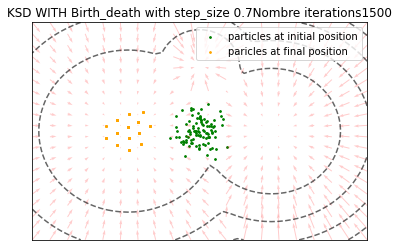

In [78]:
fac = 1
centers = [
    torch.tensor([-3, 0]),
    torch.tensor([3, 0.0]),
    torch.tensor([0.0, 3.0]),
]
# centers = [torch.tensor([0., 1.]), torch.tensor([0., -1])]
variances = [0.5, 0.3, 0.1]
weights = [0.5, 0.5, 0.5]
score, potential, sampler = make_mog(centers, variances, weights)

n_samples = 100
p = 2


x = 0.5 * torch.randn(n_samples, p)
bw = 1
x1,t1,ls1,l1=new_death_birth_withnoise1(x.clone(), score, 0.7,max_iter=1500,bw=bw,store=True,birth_death=True)

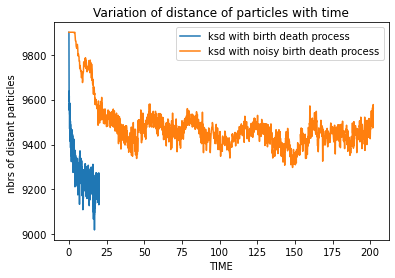

In [80]:
plt.plot(t1,l1,label="ksd with birth death process")
plt.plot(t2,l2,label="ksd with noisy birth death process")
plt.xlabel("TIME")
plt.ylabel("nbrs of distant particles ")
plt.title("Variation of distance of particles with time")
plt.legend()
plt.show()

Algorithme de SVGD

In [164]:
def svgd(x0, score, step, max_iter=1000, bw=1,verbose=False,store=False,sample=None):
    
    x = x0.detach().clone()
    plt.scatter(x[:, 0], x[:, 1], s=3, color="green", zorder=1)
    n_samples, n_features = x.shape
    sample1=np.histogram(sample)[0]

    if store:
        storage = []
        timer = []
        t0 = time()
        loss_list = []
    for i in range(max_iter):
        if store:
            
            storage.append(x.clone())
          
            timer.append(time() - t0)
        d = (x[:, None, :] - x[None, :, :])
        dists = (d ** 2).sum(axis=-1)

        k = torch.exp(- dists / bw / 2)
        k_der = d * k[:, :, None] / bw #le diffferentiel de noyau
        scores_x = score(x)
        ks = k.mm(scores_x)
        kd = k_der.sum(axis=0)
        direction = (ks - kd) / n_samples #construire la direction de svgd


        x += step * direction #mise a jour de la position avec le svgd
        y=np.histogram(x)[0]
        kl=entropy(y,sample1) #calculer le kl entre la distribution actuelle avec la distribution cible
        loss_list.append(kl) #construire la loss liste 
    plt.scatter(x[:, 0], x[:, 1], s=3, color="orange", zorder=1)
    plt.legend(["particles at initial position ", "particles at final position"])
    x_ = np.linspace(-7, 7)
    y_ = np.linspace(-5, 5)
    X, Y = np.meshgrid(x_, y_)
    XX = torch.tensor(np.array([X.ravel(), Y.ravel()]).T)
    Z = potential(XX).reshape(X.shape).detach().numpy()
    plt.contour(X, Y, Z, levels=5, colors="k", alpha=0.6)

    x_ = np.linspace(min(x_), max(x_), 20)
    y_ = np.linspace(min(y_), max(y_), 20)
    X, Y = np.meshgrid(x_, y_)
    XX = torch.tensor(np.array([X.ravel(), Y.ravel()]).T)
    score_z = score(XX)
    u = score_z[:, 0].reshape(X.shape).detach().numpy()
    v = score_z[:, 1].reshape(X.shape).detach().numpy()
    plt.quiver(X, Y, u, v, color="red", alpha=0.2)
    plt.tick_params(
                    axis="both",
                    which="both",
                    bottom=False,
                    top=False,
                    labelbottom=False,
                    left=False,
                    right=False,
                    labelleft=False,
                )
    plt.xlim(min(x_), max(x_))
    plt.ylim(min(y_), max(y_)) 
    plt.title("SVGD WITH step_size "+str(step)+"nombre_iterations"+str(max_iter))
    plt.show()
    if store:
        return x, storage, timer,loss_list
    return x

SVGD with simple Gaussien

In [106]:
def potential(x):
    return (x ** 2).sum(dim=1)
def score(x):
    return -x/0.3
def sampler(n_points):
    return math.sqrt(0.3) * torch.randn(n_points, 2)


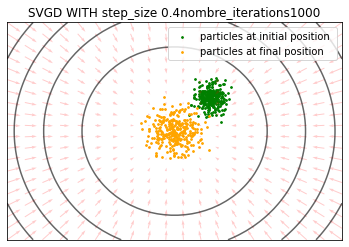

In [157]:
n_samples = 300
p = 2
x = 1.5 + torch.randn(n_samples, p) / 3
bw = 1
x2,t2,ls2,lost2=svgd(x.clone(), score, 0.4,max_iter=1000,bw=bw,store=True, verbose=False,sample=sampler(n_samples))


comparison de svgd avec le KSD

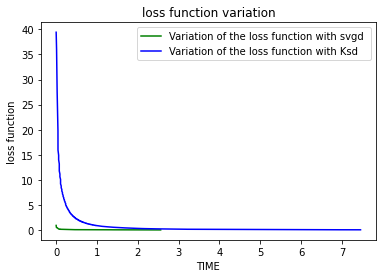

In [158]:
plt.plot(ls2,lost2,color='g',label='Variation of the loss function with svgd ')
plt.plot(t1,ls1,color='b',label='Variation of the loss function with Ksd ')
plt.xlabel("TIME")
plt.ylabel("loss function")
plt.title("loss function variation")
plt.legend()
plt.show()


Dessiner la variation de loss fonction avec svgd

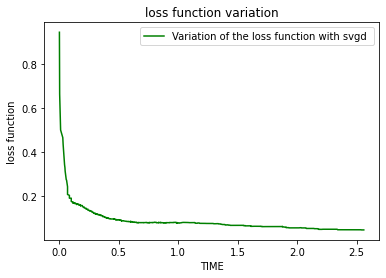

In [159]:
plt.plot(ls2,lost2,color='g',label='Variation of the loss function with svgd ')
plt.xlabel("TIME")
plt.ylabel("loss function")
plt.title("loss function variation")
plt.legend()
plt.show()

SVGD WITH MIXTURE GAUSSIEN

In [165]:
def make_mog(centers, vars, weights):
    weights = torch.tensor(weights)
    weights /= weights.sum()

    def score(x):
        den = 0
        top = 0
        for center, var, weight in zip(centers, vars, weights):
            exp = torch.exp(-0.5 * ((x - center) ** 2).sum(axis=1) / var)
            den += weight * exp
            top += weight * exp[:, None] * (x - center) / var
        return -top / den[:, None]

    def potential(x):
        op = 0.0
        for center, var, weight in zip(centers, vars, weights):
            exp = torch.exp(-0.5 * ((x - center) ** 2).sum(axis=1) / var)
            op += weight * exp
        return torch.log(op)

    def sampler(n_samples):
        x = []
        for c, v, w in zip(centers, vars, weights):
            z = torch.randn(int(n_samples * w), 2)
            z *= np.sqrt(v)
            z += c
            x.append(z.clone())
        return torch.cat(x)

    return score, potential, sampler

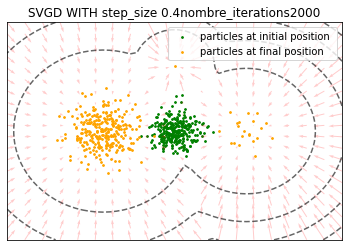

In [176]:
ac = 1
centers = [
    torch.tensor([-3, 0]),
    torch.tensor([3, 0.0]),
    torch.tensor([0.0, 3.0]),
]
# centers = [torch.tensor([0., 1.]), torch.tensor([0., -1])]
variances = [0.5, 0.3, 0.1]
weights = [0.5, 0.5, 0.5]
score, potential, sampler = make_mog(centers, variances, weights)

n_samples = 300
p = 2


x = 0.5*torch.randn(n_samples, p)
bw = 1
x4,t4,ls4,lost4=svgd(x.clone(), score, 0.4,max_iter=2000,bw=bw,store=True, verbose=False,sample=sampler(n_samples))

Langevin dynamique 

In [177]:
def death_birth_with_langevin(x0, score,step,max_iter=1000, bw=1,store=False, verbose=False, clamp=None,alpha=1,birth_death=False,sample=None):
    x = x0.clone().detach()
    plt.scatter(x[:, 0], x[:, 1], s=3, color="green", zorder=1)
    n_samples, p = x.shape
    noise_scale = np.sqrt(step * 2)
    noise = torch.randn_like(x) * noise_scale
    sample1=np.histogram(sample)[0]
    if store:
        storage = []#storage la liste de l'ensemble de x d'ou la trajectoire ksd
        timer = []#stocker les temps de nos particules  
        t0 = time()#initialliser le temps
        loss_list = []
    for i in range(max_iter + 1):
        if store:
            timer.append(time() - t0)
            storage.append(x.clone())
        scores_x = score(x)
        x[:] += step * scores_x+noise
        y=np.histogram(x)[0]
        kl=entropy(y,sample1)
        loss_list.append(kl)
        if birth_death==True: 

            d = x[:, None, :] - x[None, :, :]#on fait celle ci car on traite la matrice X comme etant tous les X , si on fait X -Y elle va pas donner la resultat voulu 
            dists = (d ** 2).sum(axis=-1)
            k = torch.exp(-dists / bw/ 2)    
            moyenne=k.sum(axis=-1)/n_samples
            beta=potential(x)+torch.log(moyenne)#calcul le terme beta de processus birth death
            new_beta=beta.detach()
            kill_inds = []
            n_cloned = 0
            for j in range(n_samples):     
                p = 1-np.exp(-alpha * new_beta[j]) #calcul la probabilité p avec laquelle on va eliminer les particules 
                r = np.random.rand()
                if beta[j] > 0:
                    if r < p:

                      kill_inds.append(j)

                elif r < (1-np.exp(alpha * new_beta[j])): #condition pour dupliquer les particules
                    x= torch.cat((x,((x[j,:]).reshape(1,2))))
                    n_cloned+=1

            # now kill the particles on the kill list
            x = kill(x,kill_inds).clone().detach()
            # and resample to control population
            delta_n = n_cloned-len(kill_inds)
            if delta_n<0:
                clone_inds = torch.randint(n_samples+delta_n,(-delta_n,), dtype=torch.long)
                x = torch.cat((x,torch.index_select(x,0,clone_inds))).clone().detach()

            if delta_n>0:
                kill_inds = (torch.randperm(x.shape[0], dtype=torch.int)[:delta_n]).numpy()
                x = kill(x,kill_inds).clone().detach()
    x3=x.clone().detach()
    plt.scatter(x3[:, 0], x3[:, 1], s=3, color="orange", zorder=1)
    plt.legend(["particles at initial position ", "particles at final position"])
    x_ = np.linspace(-7, 7)
    y_ = np.linspace(-5, 5)
    X, Y = np.meshgrid(x_, y_)
    XX = torch.tensor(np.array([X.ravel(), Y.ravel()]).T)
    Z = potential(XX).reshape(X.shape).detach().numpy()
    plt.contour(X, Y, Z, levels=5, colors="k", alpha=0.6)

    x_ = np.linspace(min(x_), max(x_), 20)
    y_ = np.linspace(min(y_), max(y_), 20)
    X, Y = np.meshgrid(x_, y_)
    XX = torch.tensor(np.array([X.ravel(), Y.ravel()]).T)
    score_z = score(XX)
    u = score_z[:, 0].reshape(X.shape).detach().numpy()
    v = score_z[:, 1].reshape(X.shape).detach().numpy()
    plt.quiver(X, Y, u, v, color="red", alpha=0.2)
    plt.tick_params(
                    axis="both",
                    which="both",
                    bottom=False,
                    top=False,
                    labelbottom=False,
                    left=False,
                    right=False,
                    labelleft=False,
                )
    plt.xlim(min(x_), max(x_))
    plt.ylim(min(y_), max(y_))
   
    if birth_death==True: 
        plt.title("Langevin WITH Birth_death with step_size "+str(step)+"Nombre iterations"+str(max_iter))
        plt.show()
    else: 
        plt.title("Langevin WITH step_size "+str(step)+"nombre_iterations"+str(max_iter))
        plt.show()
    if store:
        return x,timer,loss_list
    else:
        return x

In [178]:
def make_mog(centers, vars, weights):
    weights = torch.tensor(weights)
    weights /= weights.sum()

    def score(x):
        den = 0
        top = 0
        for center, var, weight in zip(centers, vars, weights):
            exp = torch.exp(-0.5 * ((x - center) ** 2).sum(axis=1) / var)
            den += weight * exp
            top += weight * exp[:, None] * (x - center) / var
        return -top / den[:, None]

    def potential(x):
        op = 0.0
        for center, var, weight in zip(centers, vars, weights):
            exp = torch.exp(-0.5 * ((x - center) ** 2).sum(axis=1) / var)
            op += weight * exp
        return torch.log(op)

    def sampler(n_samples):
        x = []
        for c, v, w in zip(centers, vars, weights):
            z = torch.randn(int(n_samples * w), 2)
            z *= np.sqrt(v)
            z += c
            x.append(z.clone())
        return torch.cat(x)

    return score, potential, sampler

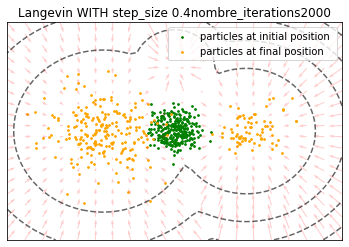

In [179]:
ac = 1
centers = [
    torch.tensor([-3, 0]),
    torch.tensor([3, 0.0]),
    torch.tensor([0.0, 3.0]),
]
# centers = [torch.tensor([0., 1.]), torch.tensor([0., -1])]
variances = [0.5, 0.3, 0.1]
weights = [0.5, 0.5, 0.5]
score, potential, sampler = make_mog(centers, variances, weights)

n_samples = 300
p = 2


x = 0.5* torch.randn(n_samples, p)
bw = 1
x5,t5,ls5= death_birth_with_langevin(x.clone(), score, 0.4,max_iter=2000, bw=bw, store=True,birth_death=False,sample=sampler(n_samples))

Comparison loss function pour svgd et Langevin

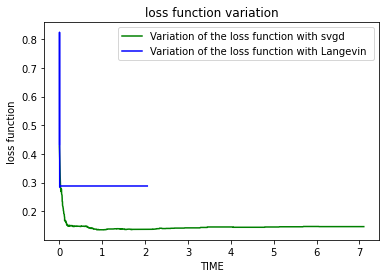

In [174]:
plt.plot(ls4,lost4,color='g',label='Variation of the loss function with svgd ')
plt.plot(t5,ls5,color='b',label='Variation of the loss function with Langevin ')
plt.xlabel("TIME")
plt.ylabel("loss function")
plt.title("loss function variation")
plt.legend()
plt.show()

In [160]:
def score(x):
    return -x/0.3
def potential(x):
    return (x ** 2).sum(dim=1)
def sampler(n_points):
    return math.sqrt(0.3) * torch.randn(n_points, 2)

0.049135546256155994
0.029390209416516273
0.03566647475028992
0.03591606067034315
0.036977600274467864
0.03672657752518124
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.03659784173190094
0.036597841731900

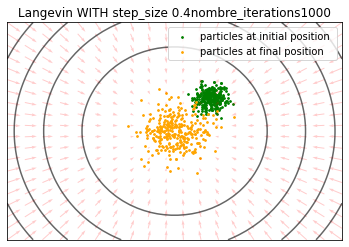

In [161]:
n_samples = 300
p = 2
x = 1.5 + torch.randn(n_samples, p) / 3
bw = 1
x3,t3,ls3= death_birth_with_langevin(x.clone(), score, 0.4,max_iter=1000, bw=bw, store=True,birth_death=False,sample=sampler(n_samples))